In [1]:
import pandas
import numpy
from sklearn.linear_model import LinearRegression #thư viện để khởi tạo mô hình hồi quy tuyến tính
from sklearn.model_selection import train_test_split #thư viện để chia bộ dữ liệu thành train và test
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score #thư viện dùng để đánh giá giữa dữ liệu thực tế và dữ liệu dự đoánD

In [2]:
data = pandas.read_csv('/kaggle/input/fish-data/Fish.csv')

In [3]:
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [4]:
data.describe().round(2)

,Weight,Length1,Length2,Length3,Height,Width
count,159.00,159.00,159.00,159.00,159.00,159.00
mean,398.33,26.25,28.42,31.23,8.97,4.42
std,357.98,10.00,10.72,11.61,4.29,1.69
min,0.00,7.50,8.40,8.80,1.73,1.05
25%,120.00,19.05,21.00,23.15,5.94,3.39
50%,273.00,25.20,27.30,29.40,7.79,4.25
75%,650.00,32.70,35.50,39.65,12.37,5.58
max,1650.00,59.00,63.40,68.00,18.96,8.14


**Kiểm tra và tiền xử lý dữ liệu**

* Thay thế hoặc loại bỏ các giá trị rỗng

* Mã hóa hoặc phân bin dữ liệu về dạng số (đối với dữ liệu phân lớp)

* Xử lý outliers (ngoại lai)

In [5]:
data.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64





**Sử dụng biểu đồ boxplot cho từng đặt trưng dùng làm biến phụ thuộc để kiểm tra outliers(ngoại lai)**

In [6]:
data_draw_boxplot_data = data.drop(columns='Species', axis=1)
data_draw_boxplot_data

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


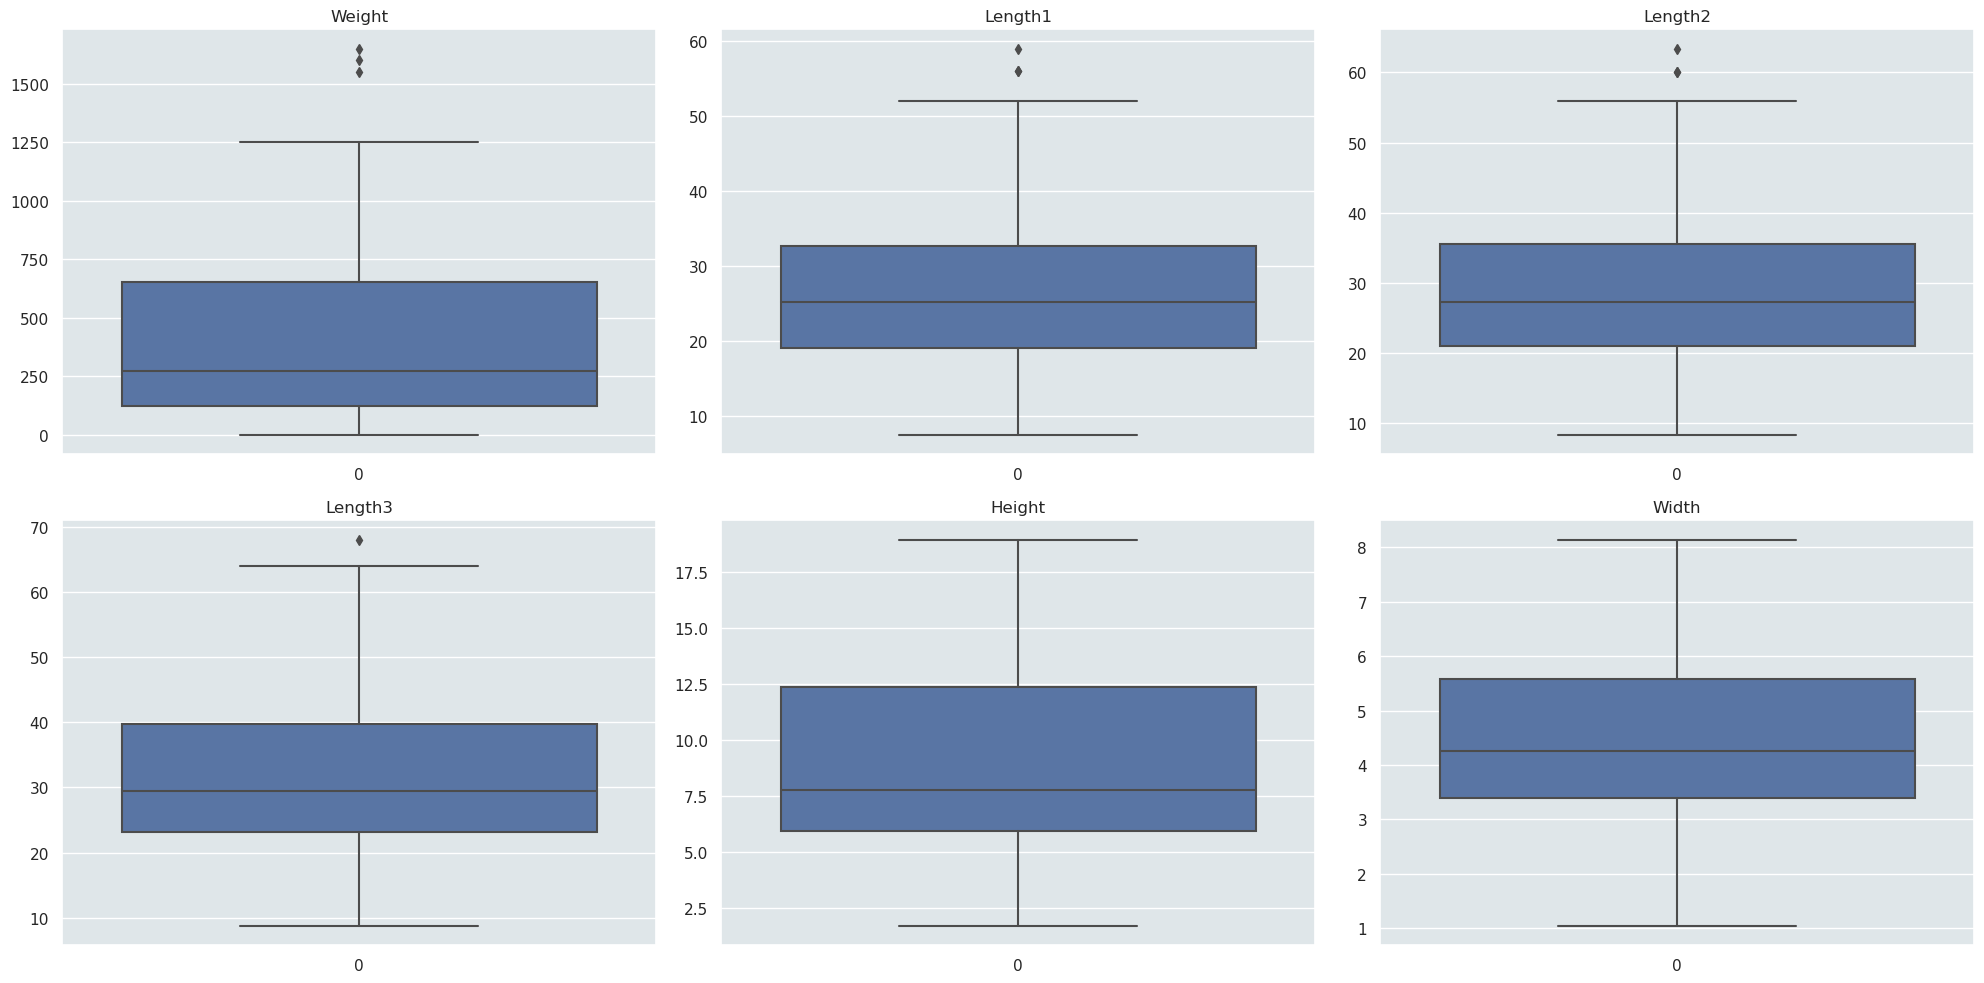

In [7]:
seaborn.set(rc={'axes.facecolor':'#dfe6e9', 'figure.facecolor':'#fff'})

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, col in zip(axes.flat, data_draw_boxplot_data.columns):
   seaborn.boxplot(data_draw_boxplot_data[col], ax=ax)
   ax.set_title(col)

plt.tight_layout()
plt.show()

--> Có thể thấy các giá trị (đặc trưng) như *Length1, Length2, Length3, Weight* là có outliers, *Width và Height* thì không

    Ta sẽ tiến hành xử lý, loại bỏ outliers

**Định nghĩa hàm tìm outliers dùng interquartile range (IQR)**

In [8]:
def find_outliers_IQR(data):
   q1=data.quantile(0.25)
   q3=data.quantile(0.75)
   IQR=q3-q1
   outliers = data[((data<(q1-1.5*IQR)) | (data>(q3+1.5*IQR)))]
   return outliers

**Tìm outliers trên các giá trị thuộc biến độc lập**

In [9]:
length1_outliers = find_outliers_IQR(data['Length1'])
length1_outliers

142    56.0
143    56.0
144    59.0
Name: Length1, dtype: float64

In [10]:
length2_outliers = find_outliers_IQR(data['Length2'])
length2_outliers

142    60.0
143    60.0
144    63.4
Name: Length2, dtype: float64

In [11]:
length3_outliers = find_outliers_IQR(data['Length3'])
length3_outliers

144    68.0
Name: Length3, dtype: float64

In [12]:
weight_outliers = find_outliers_IQR(data['Weight'])
weight_outliers

142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64

**Loại bỏ các giá trị outliers**

**Outerliers** ảnh hưởng rất nhiều về tính đúng đắn của mô hình khi xây dựng. Ta cần xử lý outliers bằng cách

* Tìm các vị trí chứa giá trị outliers
* Kiểm tra chỉnh sửa, hoặc loại bỏ nếu cần thiết

Có thể thấy, vị trí tại index = [142,143,144] chứa giá trị ngoại lai, ta tiến hành loại bỏ những hàng (records) này

In [13]:
data1 = data.drop([142,143,144])

In [14]:
data1.describe().round(2)

,Weight,Length1,Length2,Length3,Height,Width
count,156.00,156.00,156.00,156.00,156.00,156.00
mean,375.22,25.66,27.79,30.57,8.95,4.38
std,319.55,9.12,9.79,10.70,4.32,1.67
min,0.00,7.50,8.40,8.80,1.73,1.05
25%,120.00,19.00,21.00,23.02,5.93,3.37
50%,271.00,25.00,26.75,29.25,7.65,4.24
75%,612.50,32.12,35.00,39.42,12.38,5.42
max,1250.00,52.00,56.00,59.70,18.96,8.14


**Sau khi đã loại bỏ outliers, ta tiến hành kiểm tra lại dữ liệu bằng biểu đồ boxplot**

In [15]:
data_draw_boxplot = data1.drop(columns='Species', axis=1)
data_draw_boxplot

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


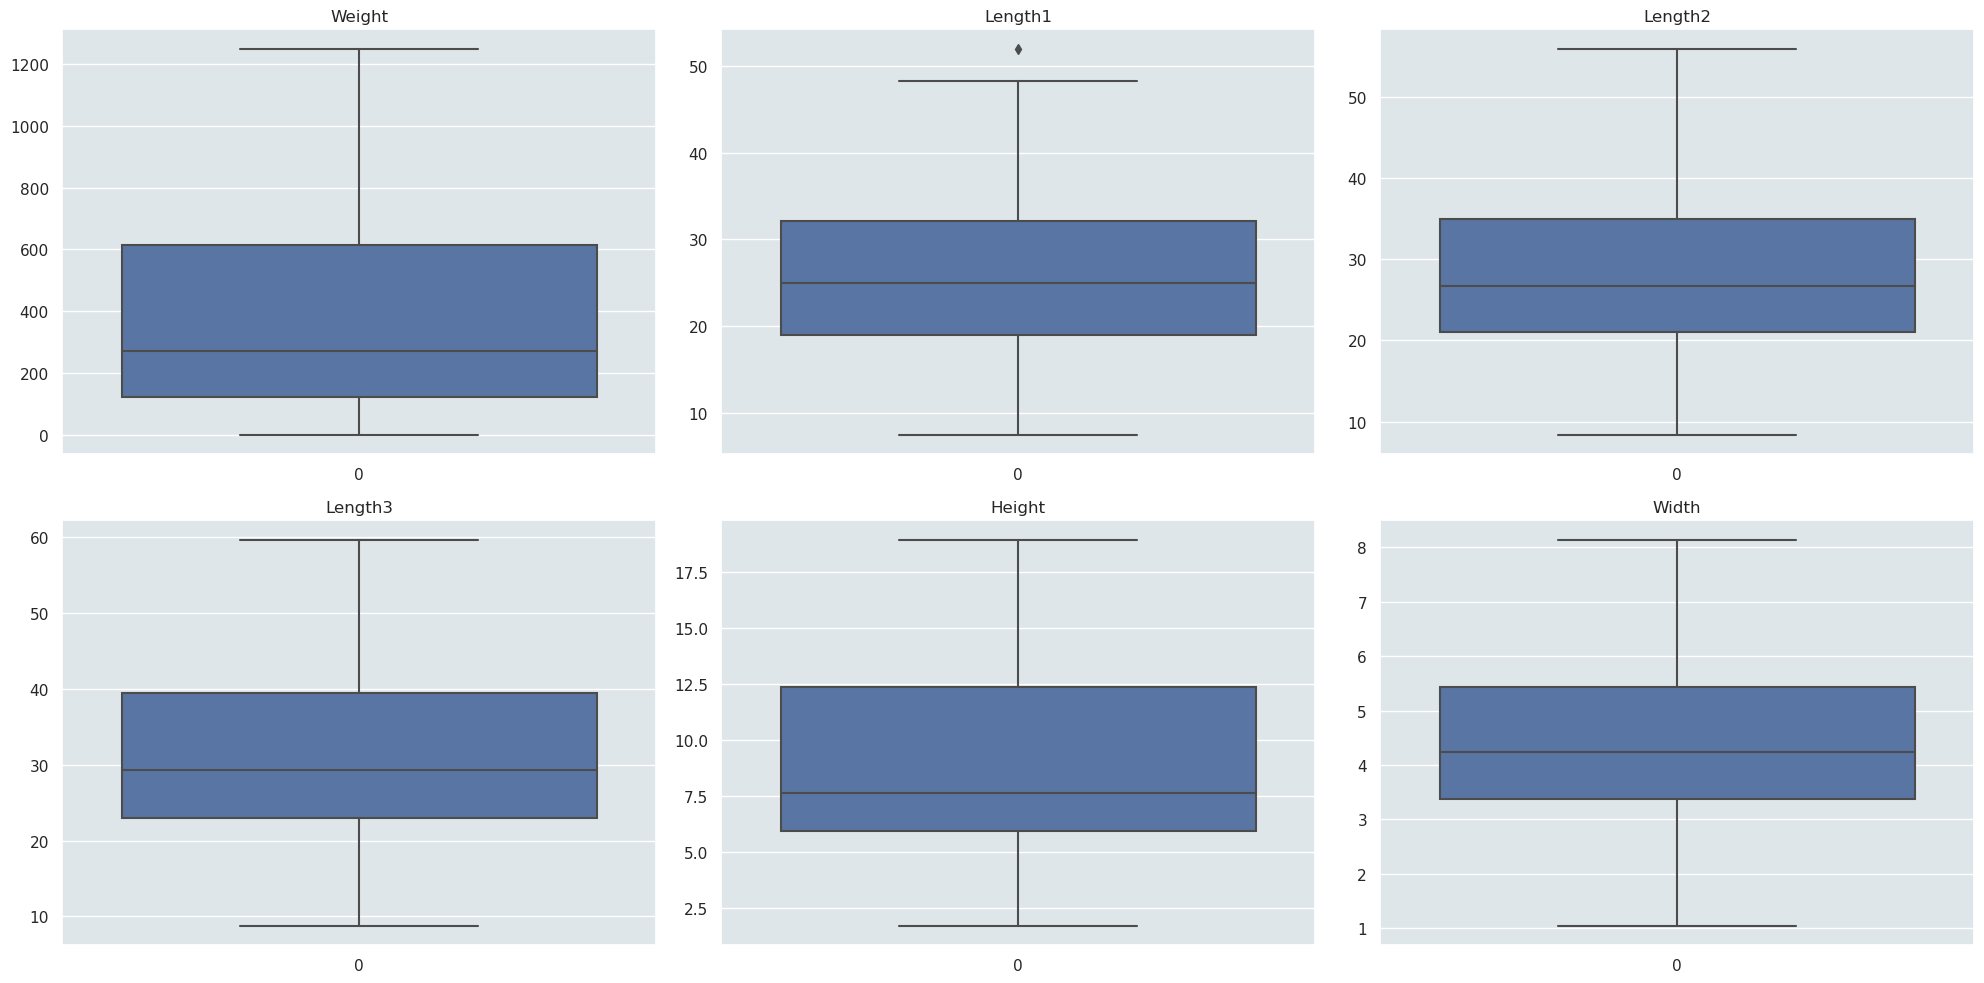

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, col in zip(axes.flat, data_draw_boxplot.columns):
   seaborn.boxplot(data_draw_boxplot[col], ax=ax)
   ax.set_title(col)
plt.tight_layout()
plt.show()

**Một số biểu đồ để trực quan hóa dữ liệu**

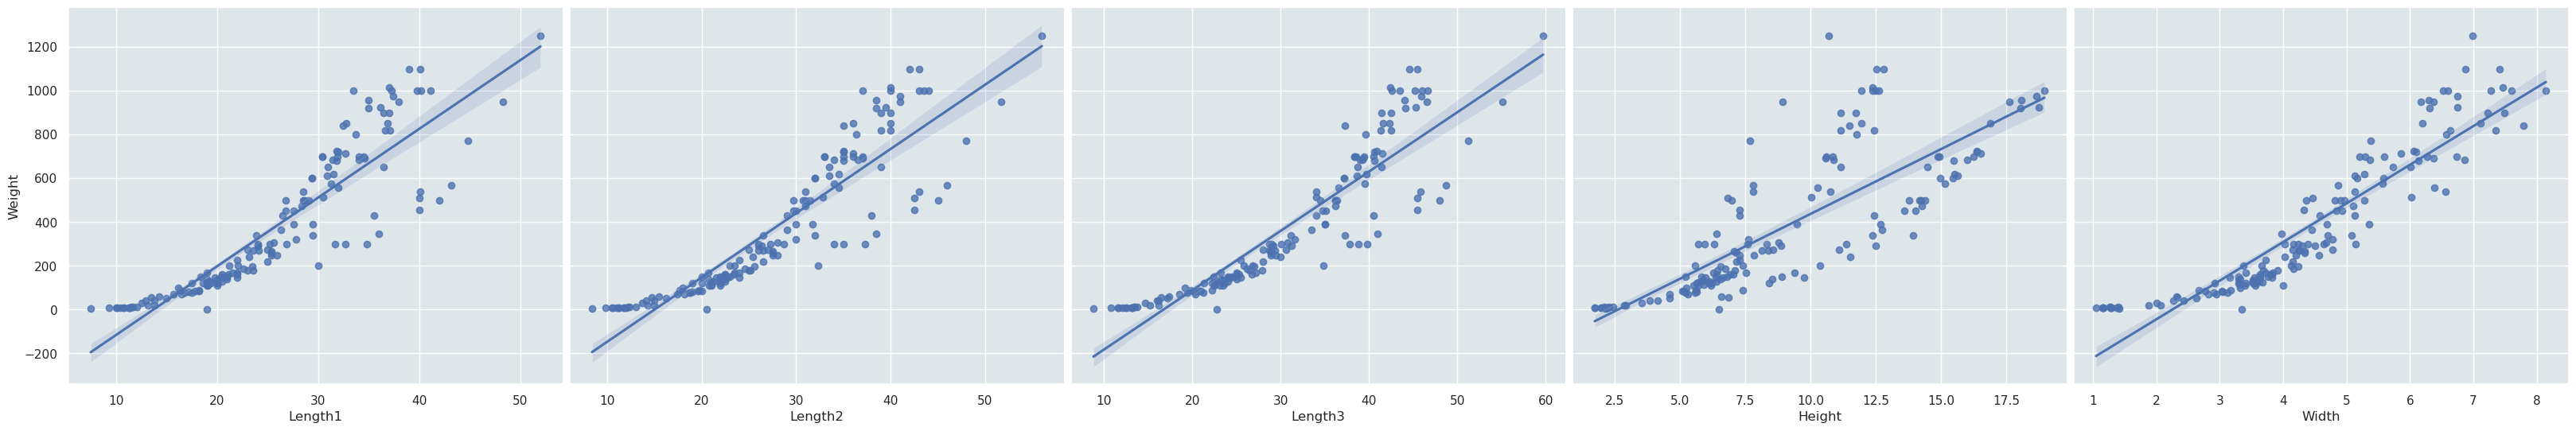

In [17]:
plt.figsize=(20, 10)
seaborn.pairplot(data1, x_vars=['Length1', 'Length2', 'Length3', 'Height', 'Width'], y_vars=['Weight'], kind='reg',height=5.5, aspect=1.2)

In [18]:
sp = data1['Species'].value_counts()
sp = pandas.DataFrame(sp)
sp.T

,Perch,Bream,Roach,Pike,Smelt,Parkki,Whitefish
Species,56,35,20,14,14,11,6


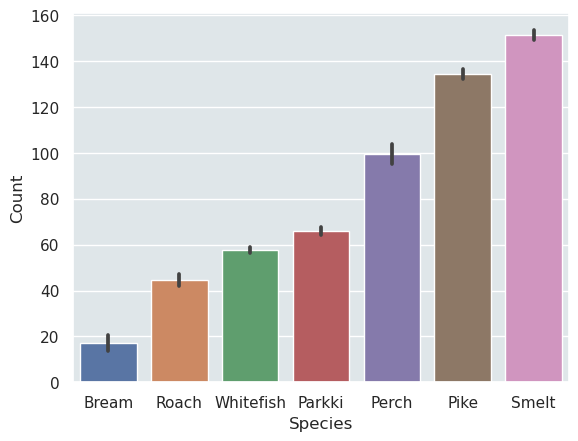

In [19]:
seaborn.barplot(x=data1['Species'], y=data1.index)
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

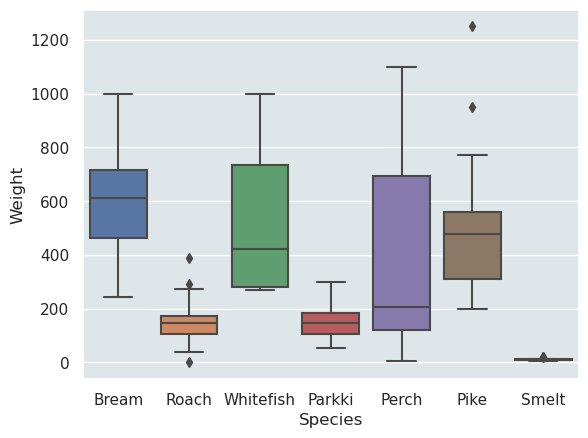

In [20]:
seaborn.boxplot(x='Species', y='Weight', data=data1)
plt.show()

**Xây dựng mô hình**

In [21]:
features = ['Length1', 'Length2', 'Length3', 'Height', 'Width']

In [22]:
X = data1[features]
y = data1['Weight']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
print('Số giá trị trong từng bộ dữ liệu')
print('X_train: ', numpy.shape(X_train))
print('y_train: ', numpy.shape(y_train))
print('X_test: ', numpy.shape(X_test))
print('y_test: ', numpy.shape(y_test))

Số giá trị trong từng bộ dữ liệu
X_train:  (124, 5)
y_train:  (124,)
X_test:  (32, 5)
y_test:  (32,)


In [25]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**Đánh giá mức độ phụ thuộc của biến phụ với biến độc lập**

In [26]:
model.score(X_test, y_test)

0.867196438874247

--> kết quả là 0.86 tương đương với 86% giá trị của biến phụ thuộc phụ thuộc vào các giá trị của biến độc lập

**Vì đây là mô hình hồi quy đa tuyến tính Multiple Linear Regression , hàm số giả thuyết có dạng** 


y = α1X1 + α2X2 + α3X3 + ... + αnXn + β

* X1 - Xn: các biến độc lập
* y: biến phụ thuộc
* α và β: các tham số không thay đổi của hàm
* n: số lượng biến độc lập

In [27]:
print('Model intercept: ', model.intercept_)
print('Model coefficients: ', model.coef_)

Model intercept:  -441.00887253881706
Model coefficients:  [ 89.93843031 -32.68619524 -37.53063323  33.07275974  60.72005923]


In [28]:
print('y = ' + str('%.2f' % model.intercept_) + ' + ' + str('%.2f' % model.coef_[0]) + '*X1 ' + str('%.2f' % model.coef_[1]) + '*X2 ' +
      str('%.2f' % model.coef_[2]) + '*X3 + ' + str('%.2f' % model.coef_[3]) + '*X4 + ' + str('%.2f' % model.coef_[4]) + '*X5')

y = -441.01 + 89.94*X1 -32.69*X2 -37.53*X3 + 33.07*X4 + 60.72*X5


**Dùng mô hình dự đoán tập X_test**

In [29]:
predicts = model.predict(X_test)

**Đánh giá mức độ phụ thuộc giữa predicts và y_test, ở đây là mức độ các giá trị giống như giữa 1 tập**

In [30]:
r2_score(y_test, predicts)

0.867196438874247

**Tạo 1 dataframe gồm 2 cột là Weight thực tế và Weight dự đoán**

In [31]:
weight_test = pandas.DataFrame(y_test)
weight_test.reset_index(drop=True, inplace=True)
weight_test.head()

,Weight
0,650.0
1,51.5
2,180.0
3,955.0
4,40.0


In [32]:
weight_predicted = pandas.DataFrame(predicts.round(2), columns=['Predicted Weight'])
weight_predicted.head()

,Predicted Weight
0,746.03
1,44.70
2,282.29
3,777.21
4,-74.80


In [33]:
weight_comparing = pandas.concat([weight_test, weight_predicted], axis=1)
weight_comparing

,Weight,Predicted Weight
0,650.0,746.03
1,51.5,44.70
2,180.0,282.29
3,955.0,777.21
4,40.0,-74.80
5,0.0,159.72
6,600.0,569.64
7,514.0,651.10
8,272.0,349.71
9,9.8,-163.68


--> Từ sự so sánh trên, ta có thể thấy các giá trị dự đoán có xu hướng sai khi Weight nhỏ

Ta sẽ dùng biểu đồ scatter để xem xét giá trị dự đoán và giá trị thực tế trên từng biến độc lập

Text(0.5, 0.98, 'So sánh giá Weight (Thực tế) - Màu xanh và Predicted Weight (Dự đoán) - Màu đỏ')

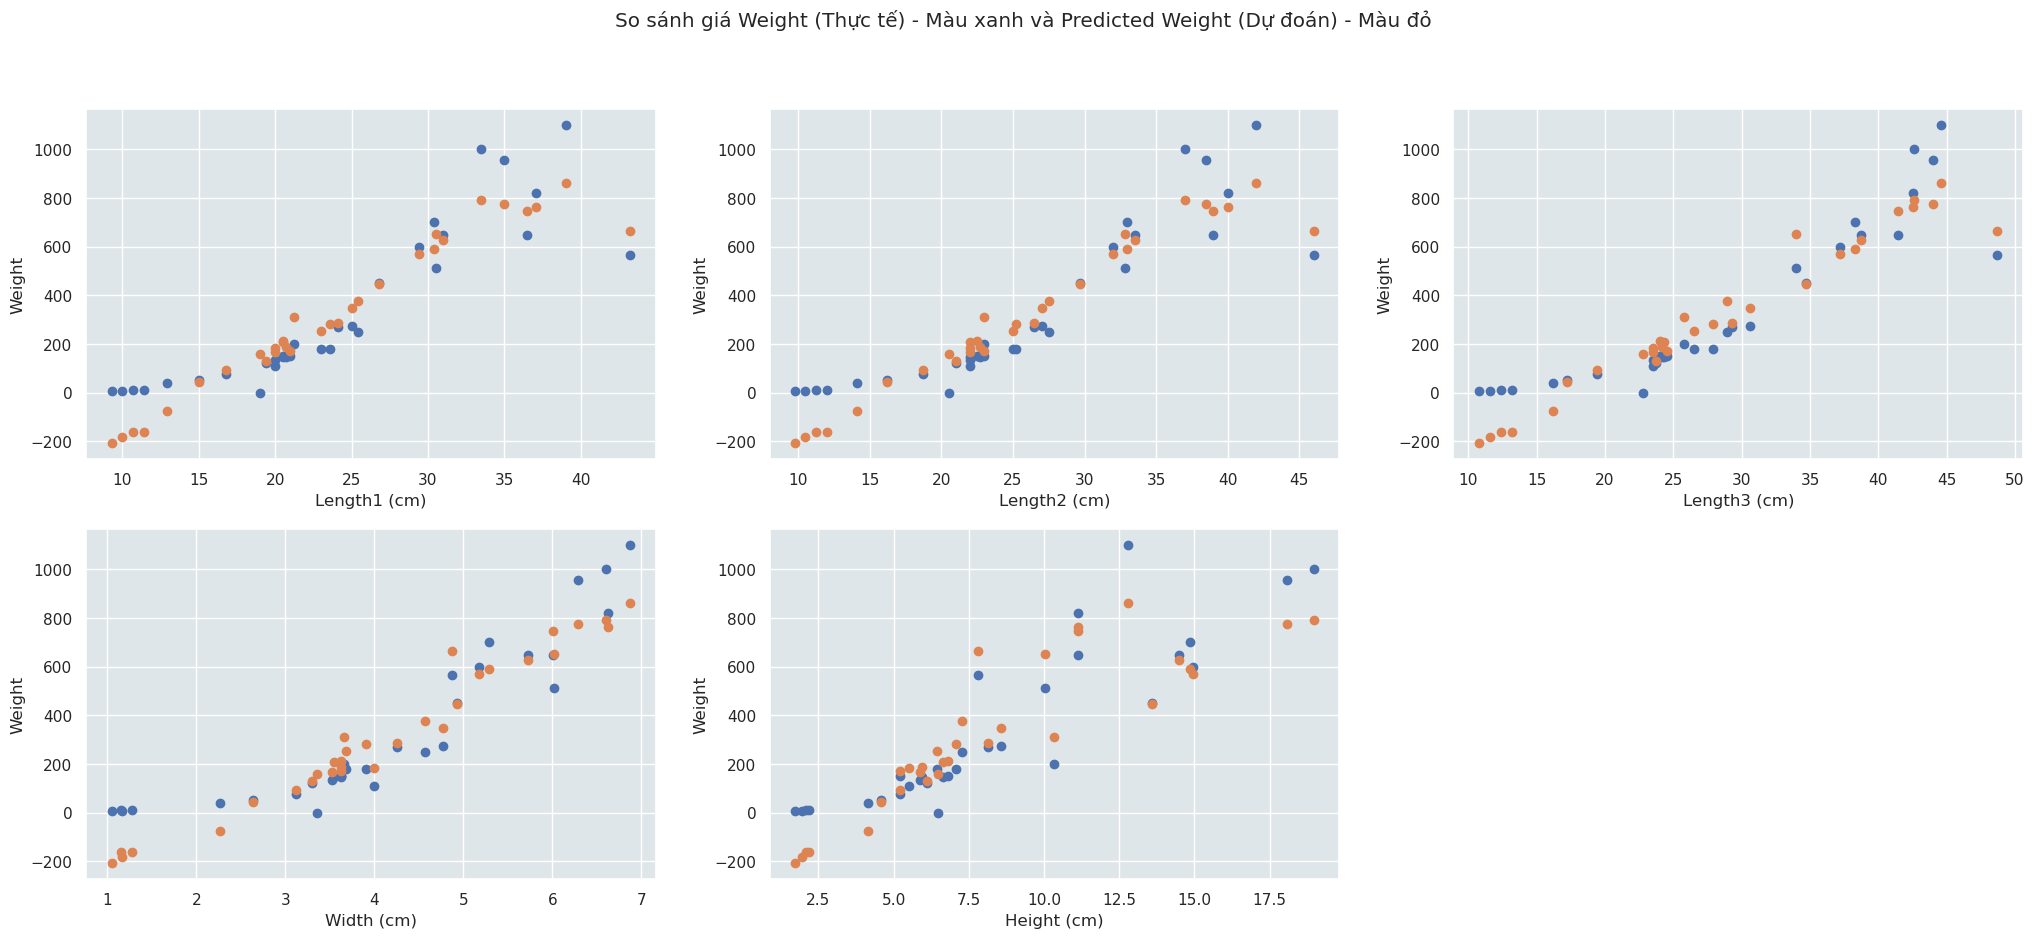

In [34]:
seaborn.set(rc={'axes.facecolor':'#dfe6e9', 'figure.facecolor':'#fff'})

fig, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[0, 0].scatter(X_test['Length1'], y_test)
ax[0, 0].scatter(X_test['Length1'], predicts)

ax[0, 0].set_xlabel('Length1 (cm)')
ax[0, 0].set_ylabel('Weight')

# new item
ax[0, 1].scatter(X_test['Length2'], y_test)
ax[0, 1].scatter(X_test['Length2'], predicts)

ax[0, 1].set_xlabel('Length2 (cm)')
ax[0, 1].set_ylabel('Weight')

# new item
ax[0, 2].scatter(X_test['Length3'], y_test)
ax[0, 2].scatter(X_test['Length3'], predicts)

ax[0, 2].set_xlabel('Length3 (cm)')
ax[0, 2].set_ylabel('Weight')

# new item
ax[1, 0].scatter(X_test['Width'], y_test)
ax[1, 0].scatter(X_test['Width'], predicts)

ax[1, 0].set_xlabel('Width (cm)')
ax[1, 0].set_ylabel('Weight')

# new item
ax[1, 1].scatter(X_test['Height'], y_test)
ax[1, 1].scatter(X_test['Height'], predicts)

ax[1, 1].set_xlabel('Height (cm)')
ax[1, 1].set_ylabel('Weight')

ax[1,2].axis('off')

fig.suptitle('So sánh giá Weight (Thực tế) - Màu xanh và Predicted Weight (Dự đoán) - Màu đỏ')